다양한 알고리즘을 사용해 성능을 비교해보고, 상위 3개 알고리즘에서 튜닝을 시작하겠습니다.

- 랜덤 포레스트(베이스)
- 엑스트라 트리
- XGB
- LGBM
- KNN
- Ridge, Lasso, LR


In [374]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression, Ridge, Lasso

import warnings
warnings.filterwarnings("ignore")

## Preprocessing

In [2]:
PATH = r'C:\Users\Wyatt\wyatt37\data\energy'

In [92]:
train_col = ['num', 'date_time', 'target', 'temp', 'wind', 'humid', 'rain', 'sunny', 'cooler', 'solar']
test_col = ['num', 'date_time', 'temp', 'wind', 'humid', 'rain', 'sunny', 'cooler', 'solar']

In [93]:
train = pd.read_csv(PATH + '\\train.csv', encoding='cp949', names=train_col, header=0)
test = pd.read_csv(PATH + '\\test.csv', encoding='cp949', names=test_col, header=0)
sub = pd.read_csv(PATH + '\\sample_submission.csv', encoding='cp949')

In [94]:
def make_time(train):
    train['date_time'] = pd.to_datetime(train.date_time)
    
    # 1차 time / 지지
    train['month'] = train.date_time.dt.month                    # 월(숫자)
    train['day'] = train.date_time.dt.day                        # 일(숫자)
    train['hour'] = train.date_time.dt.hour                      # 시(숫자)
    train['weekday'] = train.date_time.dt.weekday                # 시(숫자)
    train['dayofyear'] = train.date_time.dt.dayofyear            # 연 기준 몇일째(숫자)
    train['weekofyear'] = train.date_time.dt.isocalendar().week  # 연 기준 몇주째(숫자) (=week)
    
    # 2차 time / 지지
    train['month_start'] = train.date_time.dt.is_month_start
    train['month_end'] = train.date_time.dt.is_month_end
    
    # 여기까지
    
    #train.drop(['date_time', 'datetime'], axis=1, inplace=True)
    
    train.weekofyear = train.weekofyear.astype(int)
    
    return train

In [95]:
train = make_time(train)
test = make_time(test)

In [96]:
# cooler와 solar를 넣어주겠습니다.
for i in range(1, 61):
    test.loc[test.num == i, 'cooler'] = train.loc[train.num == i, 'cooler'].mean()
    test.loc[test.num == i, 'solar'] = train.loc[train.num == i, 'solar'].mean()

In [97]:
test[['temp', 'wind', 'humid', 'rain', 'sunny']] = test[['temp', 'wind', 'humid', 'rain', 'sunny']].interpolate(method='values').round(1)

In [98]:
# 6월 6일은 현충일
# 8월 15일은 광복절
# 8월 17일은 임시공휴일

# 휴일이 많지 않으니, 주말에 포함시키자.

train.loc[train.weekday >= 5, 'holiday'] = True
train.loc[train.weekday < 5, 'holiday'] = False
train.loc[(train.month == 8) & (train.day == 17), 'holiday'] = True

test.loc[test.weekday >= 5, 'holiday'] = True
test.loc[test.weekday < 5, 'holiday'] = False

train.holiday = train.holiday.astype('bool')
test.holiday = test.holiday.astype('bool')

In [99]:
train

,num,date_time,target,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,weekofyear,month_start,month_end,holiday
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,6,1,0,0,153,23,True,False,False
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,6,1,1,0,153,23,True,False,False
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,6,1,2,0,153,23,True,False,False
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,6,1,3,0,153,23,True,False,False
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,6,1,4,0,153,23,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0,8,24,19,0,237,35,False,False,False
122396,60,2020-08-24 20:00:00,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0,8,24,20,0,237,35,False,False,False
122397,60,2020-08-24 21:00:00,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0,8,24,21,0,237,35,False,False,False
122398,60,2020-08-24 22:00:00,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0,8,24,22,0,237,35,False,False,False


## train_test_split

In [100]:
x_train = train.loc[train.date_time < '2020-08-18', ~train.columns.isin(['target', 'date_time'])]
y_train = train.loc[train.date_time < '2020-08-18'][['num', 'target']]
x_test = train.loc[train.date_time >= '2020-08-18', ~train.columns.isin(['target', 'date_time'])]
y_test = train.loc[train.date_time >= '2020-08-18'][['num', 'target']]

In [101]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((112320, 17), (112320, 2), (10080, 17), (10080, 2))

In [102]:
x_train.head()

,num,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,weekofyear,month_start,month_end,holiday
0,1,17.6,2.5,92.0,0.8,0.0,0.0,0.0,6,1,0,0,153,23,True,False,False
1,1,17.7,2.9,91.0,0.3,0.0,0.0,0.0,6,1,1,0,153,23,True,False,False
2,1,17.5,3.2,91.0,0.0,0.0,0.0,0.0,6,1,2,0,153,23,True,False,False
3,1,17.1,3.2,91.0,0.0,0.0,0.0,0.0,6,1,3,0,153,23,True,False,False
4,1,17.0,3.3,92.0,0.0,0.0,0.0,0.0,6,1,4,0,153,23,True,False,False


In [103]:
y_train.head()

,num,target
0,1,8179.056
1,1,8135.640
2,1,8107.128
3,1,8048.808
4,1,8043.624


In [104]:
for i in range(1, 61):
    # 빌딩별로 train_x을 만듭니다.
    globals()['x_train_{}'.format(i)] = x_train.loc[x_train.num == i, ~x_train.columns.isin(['num', 'cooler', 'solar'])]
    
    # 빌딩별로 train_y 를 만듭니다.
    globals()['y_train_{}'.format(i)] = y_train.loc[y_train.num == i, 'target']
    
    # 빌딩별로 test_x 를 만듭니다.
    globals()['x_test_{}'.format(i)] = x_test.loc[x_test.num == i, ~x_test.columns.isin(['num', 'cooler', 'solar'])]
    
    # 빌딩별로 train_y 를 만듭니다.
    globals()['y_test_{}'.format(i)] = y_test.loc[y_test.num == i, 'target']

In [105]:
x_train_60.shape, y_train_60.shape, x_test_60.shape, y_test_60.shape

((1872, 14), (1872,), (168, 14), (168,))

## Metric

In [51]:
# metric
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred)))*100

## Random Forest(Base)

In [173]:
preds = []
fe = []
oob_scores = []
scores = []
for i in tqdm(range(1, 61)):
    model = RandomForestRegressor(random_state=42, oob_score=True)
    model.fit(globals()['x_train_{}'.format(i)], globals()['y_train_{}'.format(i)])
    pred = model.predict(globals()['x_test_{}'.format(i)])
    preds.append(pred.tolist())
    fe.append(model.feature_importances_)
    oob_scores.append(model.oob_score_)
    scores.append(SMAPE(globals()['y_test_{}'.format(i)], pred))

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:36<00:00,  1.65it/s]


In [174]:
np.sum(oob_scores), np.sum(scores)

(57.072131631633866, 198.97561335920895)

데이터 타입이 object임에도, 값이 True/Flase면 랜포는 불리언으로 알아먹는다.

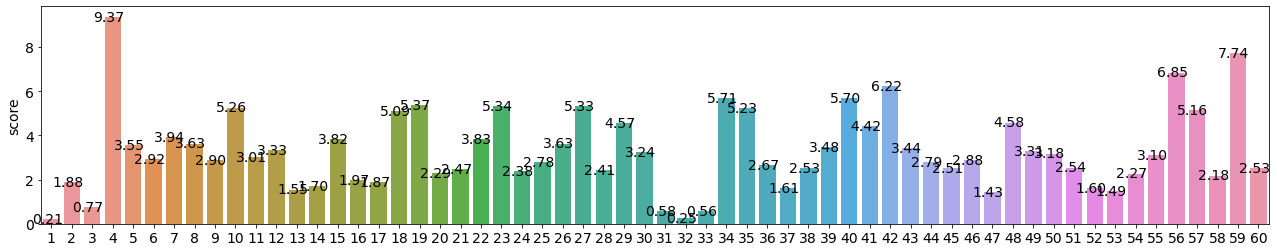

In [175]:
score_df = pd.DataFrame(scores, index=list(range(1, 61)), columns=['score'])
plt.figure(figsize=(22, 4))
plots = sns.barplot(data=score_df, x=score_df.index, y='score')

for bar in plots.patches:
    height = bar.get_height()
    plt.text(bar.get_x()+ 0.25 * bar.get_width(), bar.get_height(),
             '{:.2f}'.format(height),
             ha='center', va='center')


plt.show()

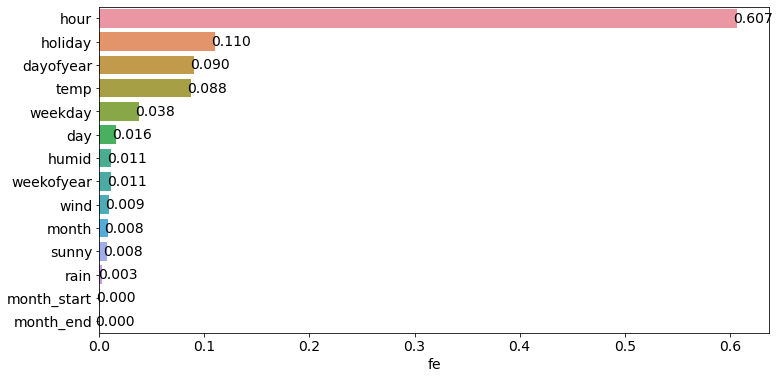

In [176]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "14"

fe_avg = pd.DataFrame(np.mean(fe, axis=0),
                      index=x_train_60.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(12, 6))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

## Extra Trees

### Bootstrap=True

In [177]:
preds = []
fe = []
oob_scores = []
scores = []
for i in tqdm(range(1, 61)):
    model = ExtraTreesRegressor(random_state=42, bootstrap=True ,oob_score=True)
    model.fit(globals()['x_train_{}'.format(i)], globals()['y_train_{}'.format(i)])
    pred = model.predict(globals()['x_test_{}'.format(i)])
    preds.append(pred.tolist())
    fe.append(model.feature_importances_)
    oob_scores.append(model.oob_score_)
    scores.append(SMAPE(globals()['y_test_{}'.format(i)], pred))

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:21<00:00,  2.86it/s]


In [178]:
np.sum(oob_scores), np.sum(scores)

(56.804123982937725, 188.2261855348892)

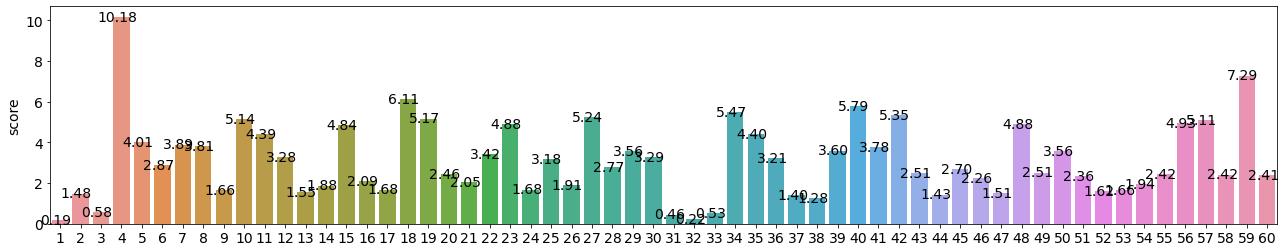

In [179]:
score_df = pd.DataFrame(scores, index=list(range(1, 61)), columns=['score'])
plt.figure(figsize=(22, 4))
plots = sns.barplot(data=score_df, x=score_df.index, y='score')

for bar in plots.patches:
    height = bar.get_height()
    plt.text(bar.get_x()+ 0.25 * bar.get_width(), bar.get_height(),
             '{:.2f}'.format(height),
             ha='center', va='center')


plt.show()

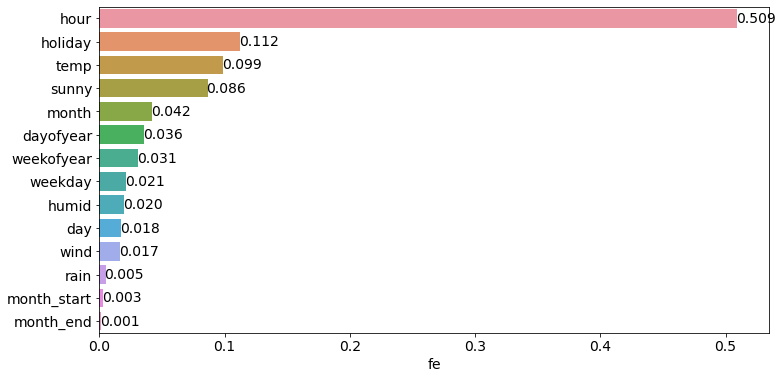

In [180]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "14"

fe_avg = pd.DataFrame(np.mean(fe, axis=0),
                      index=x_train_60.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(12, 6))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

### Bootstrap=False

In [181]:
preds = []
fe = []
oob_scores = []
scores = []
for i in tqdm(range(1, 61)):
    model = ExtraTreesRegressor(random_state=42)
    model.fit(globals()['x_train_{}'.format(i)], globals()['y_train_{}'.format(i)])
    pred = model.predict(globals()['x_test_{}'.format(i)])
    preds.append(pred.tolist())
    fe.append(model.feature_importances_)
    #oob_scores.append(model.oob_score_)
    scores.append(SMAPE(globals()['y_test_{}'.format(i)], pred))

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:24<00:00,  2.40it/s]


In [182]:
np.sum(oob_scores), np.sum(scores)

(0.0, 185.70091087065805)

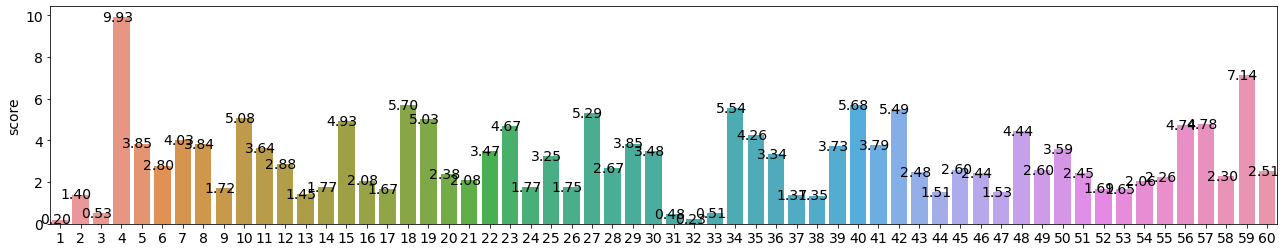

In [183]:
score_df = pd.DataFrame(scores, index=list(range(1, 61)), columns=['score'])
plt.figure(figsize=(22, 4))
plots = sns.barplot(data=score_df, x=score_df.index, y='score')

for bar in plots.patches:
    height = bar.get_height()
    plt.text(bar.get_x()+ 0.25 * bar.get_width(), bar.get_height(),
             '{:.2f}'.format(height),
             ha='center', va='center')


plt.show()

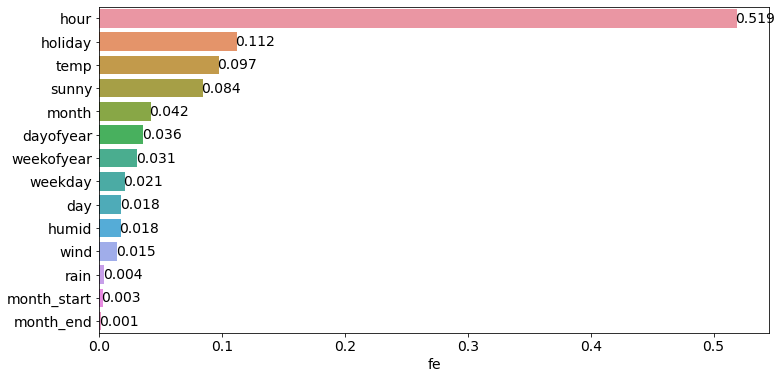

In [184]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "14"

fe_avg = pd.DataFrame(np.mean(fe, axis=0),
                      index=x_train_60.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(12, 6))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

## LGBM

In [186]:
params = {"categorical_feature": [5, 6, 7, 8, 11, 12, 13]}

In [187]:
preds = []
fe = []
oob_scores = []
scores = []
for i in tqdm(range(1, 61)):
    model = LGBMRegressor(random_state=42, **params)
    model.fit(globals()['x_train_{}'.format(i)], globals()['y_train_{}'.format(i)])
    pred = model.predict(globals()['x_test_{}'.format(i)])
    preds.append(pred.tolist())
    fe.append(model.feature_importances_)
    #oob_scores.append(model.oob_score_)
    scores.append(SMAPE(globals()['y_test_{}'.format(i)], pred))

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 10.84it/s]


In [188]:
np.sum(oob_scores), np.sum(scores)

(0.0, 196.5987738093662)

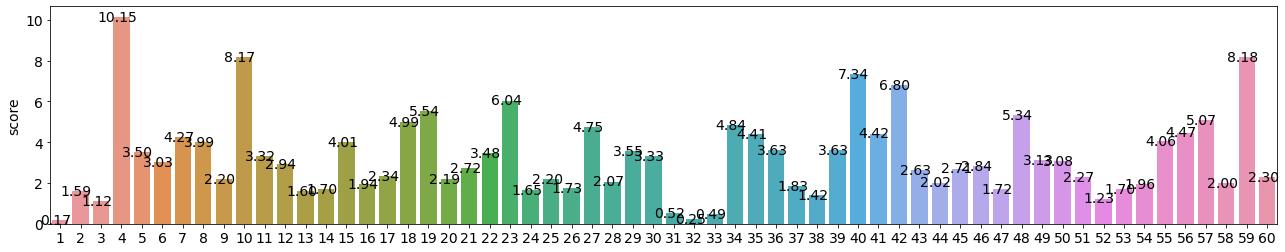

In [189]:
score_df = pd.DataFrame(scores, index=list(range(1, 61)), columns=['score'])
plt.figure(figsize=(22, 4))
plots = sns.barplot(data=score_df, x=score_df.index, y='score')

for bar in plots.patches:
    height = bar.get_height()
    plt.text(bar.get_x()+ 0.25 * bar.get_width(), bar.get_height(),
             '{:.2f}'.format(height),
             ha='center', va='center')


plt.show()

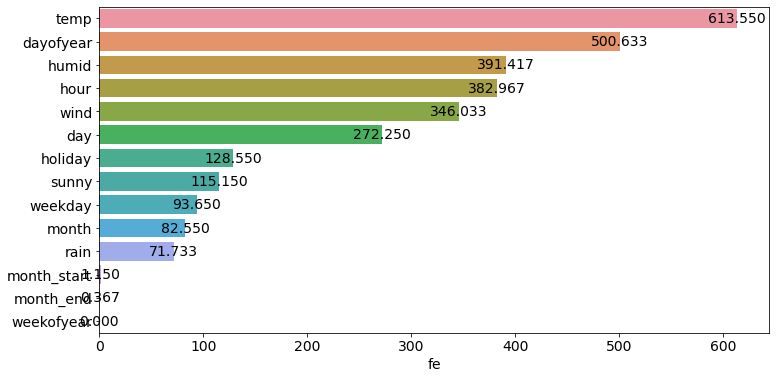

In [190]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "14"

fe_avg = pd.DataFrame(np.mean(fe, axis=0),
                      index=x_train_60.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(12, 6))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

## XGB

In [165]:
preds = []
fe = []
oob_scores = []
scores = []
for i in tqdm(range(1, 61)):
    model = XGBRegressor(random_state=42)
    model.fit(globals()['x_train_{}'.format(i)], globals()['y_train_{}'.format(i)])
    pred = model.predict(globals()['x_test_{}'.format(i)])
    preds.append(pred.tolist())
    fe.append(model.feature_importances_)
    #oob_scores.append(model.oob_score_)
    scores.append(SMAPE(globals()['y_test_{}'.format(i)], pred))

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.76it/s]


In [166]:
np.sum(oob_scores), np.sum(scores)

(0.0, 211.81447945017482)

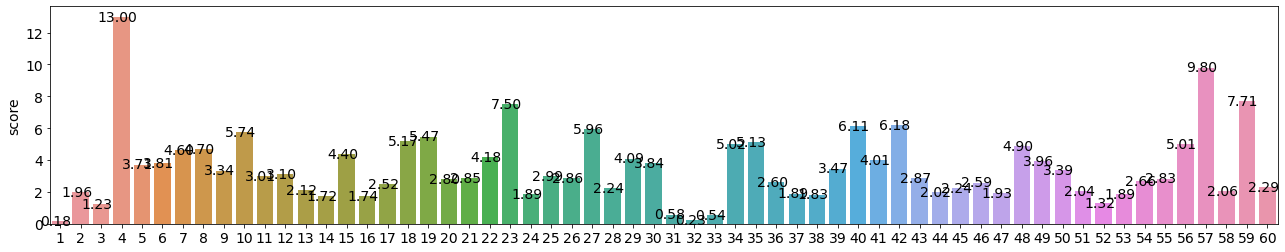

In [167]:
score_df = pd.DataFrame(scores, index=list(range(1, 61)), columns=['score'])
plt.figure(figsize=(22, 4))
plots = sns.barplot(data=score_df, x=score_df.index, y='score')

for bar in plots.patches:
    height = bar.get_height()
    plt.text(bar.get_x()+ 0.25 * bar.get_width(), bar.get_height(),
             '{:.2f}'.format(height),
             ha='center', va='center')


plt.show()

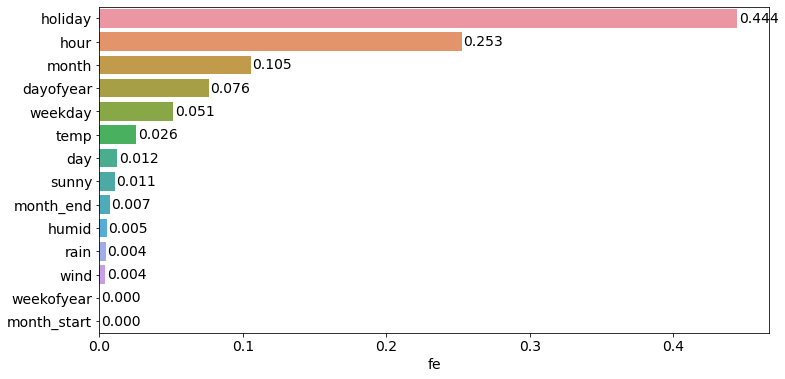

In [168]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "14"

fe_avg = pd.DataFrame(np.mean(fe, axis=0),
                      index=x_train_60.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(12, 6))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

## RidgeCV

In [382]:
preds = []
fe = []
oob_scores = []
scores = []
for i in tqdm(range(1, 61)):
    model = Ridge(normalize=True, alpha=1.)
    model.fit(globals()['x_train_{}'.format(i)], globals()['y_train_{}'.format(i)])
    pred = model.predict(globals()['x_test_{}'.format(i)])
    preds.append(pred.tolist())
    fe.append(model.coef_)
    #oob_scores.append(model.oob_score_)
    scores.append(SMAPE(globals()['y_test_{}'.format(i)], pred))

100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 204.09it/s]


In [383]:
np.sum(oob_scores), np.sum(scores)

(0.0, 641.6544899745163)

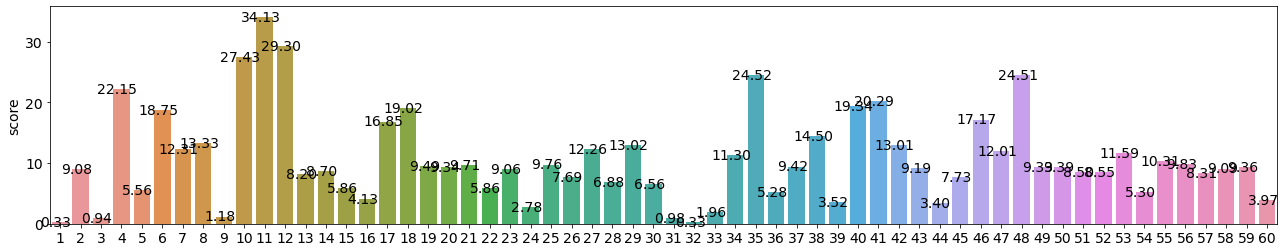

In [384]:
score_df = pd.DataFrame(scores, index=list(range(1, 61)), columns=['score'])
plt.figure(figsize=(22, 4))
plots = sns.barplot(data=score_df, x=score_df.index, y='score')

for bar in plots.patches:
    height = bar.get_height()
    plt.text(bar.get_x()+ 0.25 * bar.get_width(), bar.get_height(),
             '{:.2f}'.format(height),
             ha='center', va='center')


plt.show()

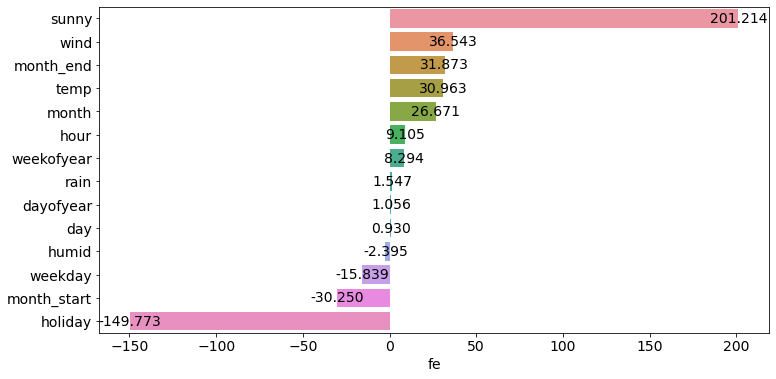

In [385]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "14"

fe_avg = pd.DataFrame(np.mean(fe, axis=0),
                      index=x_train_60.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(12, 6))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

## LassoCV

In [387]:
preds = []
fe = []
oob_scores = []
scores = []
for i in tqdm(range(1, 61)):
    model = Lasso(normalize=True, alpha=1.)
    model.fit(globals()['x_train_{}'.format(i)], globals()['y_train_{}'.format(i)])
    pred = model.predict(globals()['x_test_{}'.format(i)])
    preds.append(pred.tolist())
    fe.append(model.coef_)
    #oob_scores.append(model.oob_score_)
    scores.append(SMAPE(globals()['y_test_{}'.format(i)], pred))

100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 163.04it/s]


In [388]:
np.sum(oob_scores), np.sum(scores)

(0.0, 602.4355021910519)

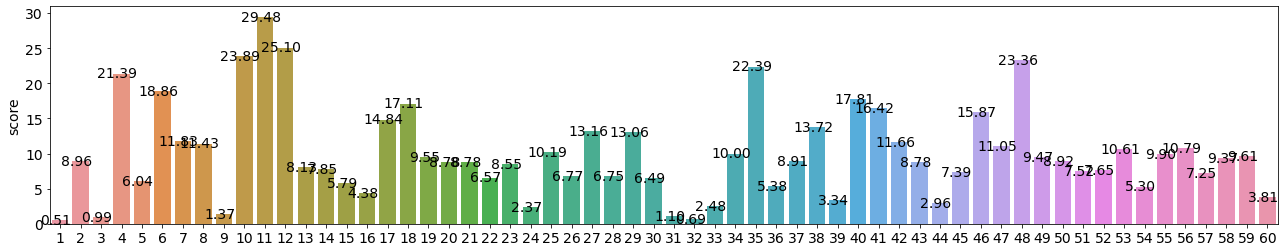

In [389]:
score_df = pd.DataFrame(scores, index=list(range(1, 61)), columns=['score'])
plt.figure(figsize=(22, 4))
plots = sns.barplot(data=score_df, x=score_df.index, y='score')

for bar in plots.patches:
    height = bar.get_height()
    plt.text(bar.get_x()+ 0.25 * bar.get_width(), bar.get_height(),
             '{:.2f}'.format(height),
             ha='center', va='center')


plt.show()

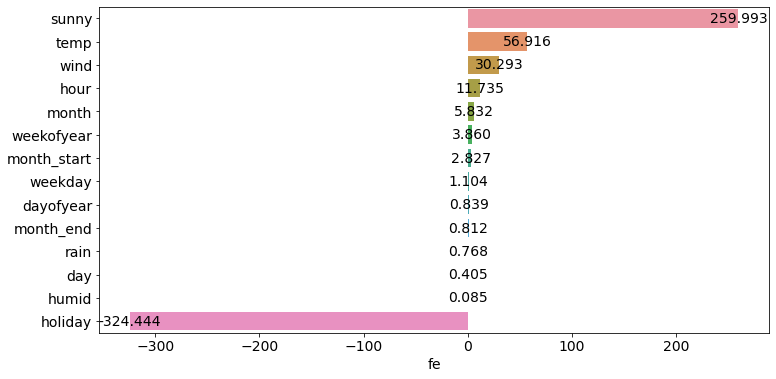

In [390]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "14"

fe_avg = pd.DataFrame(np.mean(fe, axis=0),
                      index=x_train_60.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(12, 6))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

## Parameter Tuning

### Bayes Search

참고: https://wooono.tistory.com/102

학습용 데이터 셋을 먼저 만들어 주고, 테스트용 데이터 셋을 따로 또 만들어 줍니다.

In [298]:
x_train = train.loc[train.date_time < '2020-08-18', ~train.columns.isin(['target', 'date_time'])]
y_train = train.loc[train.date_time < '2020-08-18'][['num', 'target']]
x_test = train.loc[train.date_time >= '2020-08-18', ~train.columns.isin(['target', 'date_time'])]
y_test = train.loc[train.date_time >= '2020-08-18'][['num', 'target']]

In [364]:
#목적함수 생성
def rf_cv(n_estimators, max_depth):
    
    model = RandomForestRegressor(n_estimators = int(round(n_estimators)),
                                  max_depth = int(round(max_depth)),
                                  random_state=42,
                                  n_jobs=-1)
    
    # 모델 훈련
    model.fit(x_train_bo, y_train_bo)

    # 예측값 출력
    y_pred= model.predict(x_test_bo)

    # metric 계산
    smape = SMAPE(y_test_bo, y_pred)

    # 오차 최적화로 사용할 metric 반환
    return -smape

In [365]:
pbounds = {'n_estimators' : (20, 300),
          'max_depth' : (3, 10)}

In [366]:
# 결과물을 적재할 컨테이너를 만듭니다.
preds = []
fe = []
params = []
models = []
targets = []
oob_scores = []

for i in tqdm(range(1, 61)):
    # 베이즈옵트를 위한 train_test set 을 만듭니다.
    x_train_bo = x_train.loc[x_train.num == i, ~x_train.columns.isin(['num', 'cooler', 'solar'])]
    y_train_bo = y_train.loc[y_train.num == i, 'target']
    x_test_bo = x_test.loc[x_test.num == i, ~x_test.columns.isin(['num', 'cooler', 'solar'])]
    y_test_bo = y_test.loc[y_test.num == i, 'target']
    
    # 예측을 위한 train_test set을 만듭니다.
    x_train_building = train.loc[train.num == i, ~train.columns.isin(['target', 'num', 'cooler', 'solar', 'date_time'])]
    y_train_building = train.loc[train.num == i, 'target']
    x_test_building = test.loc[test.num == i, ~test.columns.isin(['num', 'cooler', 'solar', 'date_time'])]
    
    # 베이즈 옵트를 통해 최적화된 하이퍼 파라미터를 추출합니다.
    bo = BayesianOptimization(f = rf_cv, pbounds = pbounds, verbose = 0, random_state = 0 )
    bo.maximize(init_points=10, n_iter = 20, acq='ei', xi=0.01)
    best_params = bo.max['params']
    best_target = abs(bo.max['target'])
    
    # 하이퍼 파라미터가 소수점으로 되어 있으므로, rounding을 해줍니다.
    for k, v in best_params.items():
        best_params[k] = round(v)
    
    # 최적화된 하이퍼 파라미터로 모델을 생성하고 학습합니다.
    model = RandomForestRegressor(**best_params, oob_score=True ,random_state=42)
    model.fit(x_train_building, y_train_building)
    pred = model.predict(x_test_building)
    
    # 결과물을 적재해줍니다.
    models.append(model)
    preds.append(pred.tolist())
    fe.append(model.feature_importances_)
    params.append(best_params)
    targets.append(best_target)
    oob_scores.append(model.oob_score_)

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [10:40<00:00, 10.68s/it]


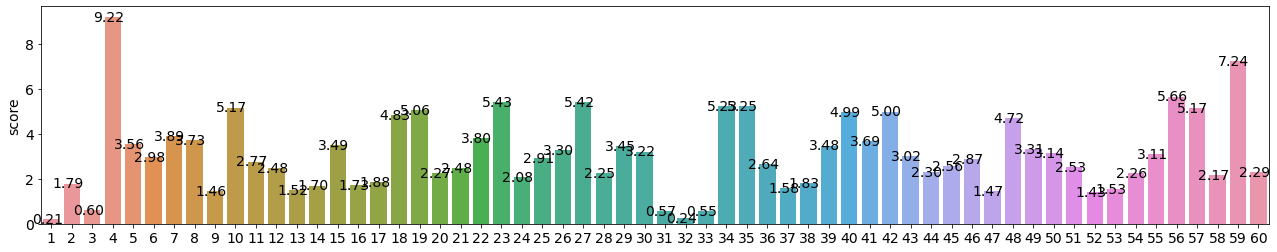

In [367]:
score_df = pd.DataFrame(targets, index=list(range(1, 61)), columns=['score'])
plt.figure(figsize=(22, 4))
plots = sns.barplot(data=score_df, x=score_df.index, y='score')

for bar in plots.patches:
    height = bar.get_height()
    plt.text(bar.get_x()+ 0.25 * bar.get_width(), bar.get_height(),
             '{:.2f}'.format(height),
             ha='center', va='center')
plt.show()

In [368]:
np.sum(oob_scores)

53.52435966762707

In [369]:
preds = sum(preds, [])

In [370]:
sub.answer = preds

In [371]:
sub.to_csv('submission/210610_bo2-rf.csv', index=False)
sub

,num_date_time,answer
0,1 2020-08-25 00,8677.143365
1,1 2020-08-25 01,8673.779181
2,1 2020-08-25 02,8670.409805
3,1 2020-08-25 03,8666.622289
4,1 2020-08-25 04,8659.821401
...,...,...
10075,60 2020-08-31 19,4027.161598
10076,60 2020-08-31 20,4013.351791
10077,60 2020-08-31 21,3832.645709
10078,60 2020-08-31 22,3611.616838


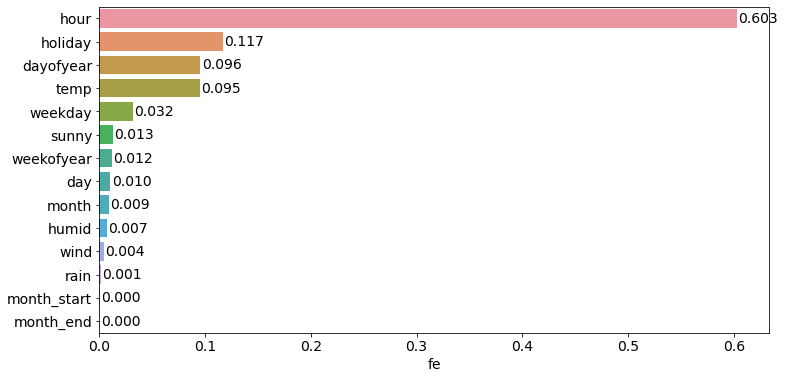

In [372]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "14"

fe_avg = pd.DataFrame(np.mean(fe, axis=0),
                      index=x_train_building.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(12, 6))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.02+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

#### sample

In [250]:
# 탐색 대상 함수 (XGBRegressor)
def RF_cv(n_estimators, max_depth):

    # 모델 정의
    model = RandomForestRegressor(n_estimators=int(n_estimators),
                                 max_depth=int(max_depth),
                                 random_state=42,
                                 n_jobs=-1)
    # 모델 훈련
    model.fit(x_train, y_train)

    # 예측값 출력
    y_pred= model.predict(x_test)

    # metric 계산
    smape = SMAPE(y_test, y_pred)

    # 오차 최적화로 사용할 metric 반환
    return -smape

In [251]:
#  bayesian-optimization 라이브러리의 BayesianOptimization 클래스 import
from bayes_opt import BayesianOptimization
import numpy as np

# 실험해보고자하는 hyperparameter 집합
pbounds = {'n_estimators': (100, 2000),
           'max_depth': (3, 15)
          }

# Bayesian optimization 객체 생성
# f : 탐색 대상 함수, pbounds : hyperparameter 집합
# verbose = 2 항상 출력, verbose = 1 최댓값일 때 출력, verbose = 0 출력 안함
# random_state : Bayesian Optimization 상의 랜덤성이 존재하는 부분을 통제 
bo=BayesianOptimization(f=RF_cv, pbounds=pbounds, verbose=2, random_state=42)    

# 메소드를 이용해 최대화 과정 수행
# init_points :  초기 Random Search 갯수
# n_iter : 반복 횟수 (몇개의 입력값-함숫값 점들을 확인할지! 많을 수록 정확한 값을 얻을 수 있다.)
# acq : Acquisition Function들 중 Expected Improvement(EI) 를 사용
# xi : exploration 강도 (기본값은 0.0)
bo.maximize(init_points=2, n_iter=10, acq='ei', xi=0.01)

# ‘iter’는 반복 회차, ‘target’은 목적 함수의 값, 나머지는 입력값을 나타냅니다. 
# 현재 회차 이전까지 조사된 함숫값들과 비교하여, 현재 회차에 최댓값이 얻어진 경우, 
# bayesian-optimization 라이브러리는 이를 자동으로 다른 색 글자로 표시하는 것을 확인할 수 있습니다

# 찾은 파라미터 값 확인
print(bo.max)

|   iter    |  target   | max_depth | n_esti... |
-------------------------------------------------


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [220]:
import xgboost as xgb

# metric
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred)))*100

# 탐색 대상 함수 (XGBRegressor)
def XGB_cv(max_depth, learning_rate, n_estimators, gamma, min_child_weight, subsample ,colsample_bytree,
           silent=True, nthread=-1):

    # 모델 정의
    model = xgb.XGBRegressor(max_depth=int(max_depth),
                            learning_rate=learning_rate,
                            n_estimators=int(n_estimators),
                            gamma=gamma,
                            min_child_weight=min_child_weight,
                            subsample=subsample,
                            colsample_bytree=colsample_bytree, 
                            nthread=nthread
                            )
    # 모델 훈련
    model.fit(x_train_4, y_train_4)

    # 예측값 출력
    y_pred= model.predict(x_test_4)

    # metric 계산
    smape = SMAPE(y_test_4, y_pred)

    # 오차 최적화로 사용할 metric 반환
    return -smape

In [212]:
bo.max['params']

{'colsample_bytree': 0.9810609591803319,
 'gamma': 59.43990020582972,
 'learning_rate': 0.15643914910740106,
 'max_depth': 4.016990709379462,
 'min_child_weight': 0.9820996416351506,
 'n_estimators': 8338.776986561905,
 'subsample': 0.7553350142558128}

In [209]:
BayesianOptimization?

Init signature:
BayesianOptimization(
    f,
    pbounds,
    random_state=None,
    verbose=2,
    bounds_transformer=None,
)
Docstring:     
Inspired/Taken from
    https://www.protechtraining.com/blog/post/879#simple-observer
File:           c:\users\wyatt\miniconda3\envs\wyatt38\lib\site-packages\bayes_opt\bayesian_optimization.py
Type:           type
Subclasses:     


In [224]:
from sklearn.model_selection import GridSearchCV

In [225]:
RandomForestRegressor?

Init signature:
RandomForestRegressor(
    n_estimators=100,
    *,
    criterion='mse',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None,
)
Docstring:     
A random forest regressor.

A random forest is a meta estimator that fits a number of classifying
decision trees on various sub-samples of the dataset and uses averaging
to improve the predictive accuracy and control over-fitting.
The sub-sample size is controlled with the `max_samples` parameter if
`bootstrap=True` (default), otherwise the whole dataset is used to build
each tree.

Read more in the :ref:`User Guide <forest>`.

Parameters
----------
n_estimators : int, default=100
    The number of trees in the fore

In [240]:
param_grid = {'max_depth': [7, 9, 11, 13],
              'max_features': ["auto", "sqrt", "log2"],
              'n_estimators': [300, 500, 700, 900]
            }

In [241]:
rf = RandomForestRegressor(random_state=42)
gs = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1)
gs.fit(x_train_4, y_train_4)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [7, 9, 11, 13],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [300, 500, 700, 900]})

In [242]:
print(gs.best_score_)
print(gs.best_params_)

0.5393125504409421
{'max_depth': 11, 'max_features': 'auto', 'n_estimators': 500}


In [243]:
rf = RandomForestRegressor(random_state=42)
gs = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1)
gs.fit(x_train_1, y_train_1)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [7, 9, 11, 13],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [300, 500, 700, 900]})

In [244]:
print(gs.best_score_)
print(gs.best_params_)

0.233204879472125
{'max_depth': 13, 'max_features': 'auto', 'n_estimators': 500}


In [15]:
preds = sum(preds, [])

In [16]:
sub.answer = preds

In [18]:
#sub.to_csv('submission/210608_537316+holiday.csv', index=False)
sub

,num_date_time,answer
0,1 2020-08-25 00,8670.35016
1,1 2020-08-25 01,8667.75168
2,1 2020-08-25 02,8665.35408
3,1 2020-08-25 03,8658.63432
4,1 2020-08-25 04,8653.11984
...,...,...
10075,60 2020-08-31 19,4064.82624
10076,60 2020-08-31 20,4014.52416
10077,60 2020-08-31 21,3839.38272
10078,60 2020-08-31 22,3520.99440


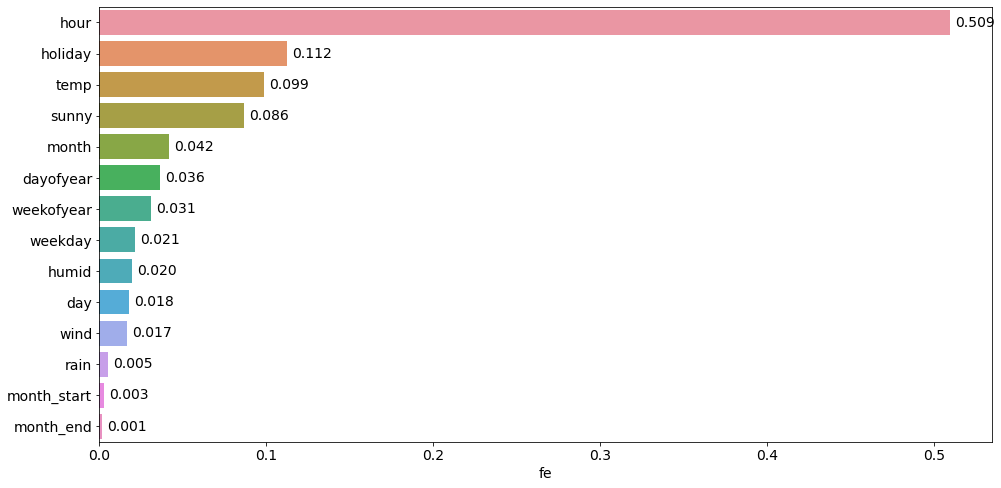

In [54]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "14"

fe_avg = pd.DataFrame(np.mean(fe, axis=0),
                      index=x_train_60.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(16, 8))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()